<a href="https://colab.research.google.com/github/arash-am/Media-Competition/blob/main/Complete_actions_Soft_2DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # used for arrays
import gym # pull the environment
import time # to get the time
import math # needed for calculations
import torch
import matplotlib.pyplot as plt

In [ ]:

def sample_multi_modal(num_samples,mean1= 0.5, mean2 = -0.5):
    # mean1, mean2 = -0.5, 0.5
    std_dev = 1 # Standard deviation for both distributions
    num_samples_per_dist = num_samples // 2
    samples1 = torch.normal(mean1, std_dev, size=(num_samples_per_dist,))
    samples2 = torch.normal(mean2, std_dev, size=(num_samples - num_samples_per_dist,))  # Adjust in case of odd num_samples
    combined_samples = torch.cat([samples1, samples2], dim=0)
    clipped_samples = torch.clamp(combined_samples, min=-1.0, max=1.0)
    return clipped_samples




class Opinon_w_media():
    def __init__(self, N=10**3, M=10, terminal_time=500,bM=5,b=25,noise_level=0.1,duration=50,nbins=10,h=0.01,r_scale=100):
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        Beta=torch.distributions.beta.Beta(3,2)
        self.s=Beta.sample(sample_shape=(N,))
        self.ym= torch.linspace(-1,1,steps=self.M)  # Uniformly distributed between -1 and 1
        self.noise_level = noise_level
        self.bM = bM
        self.b = b
        self.duration=duration
        self.action_dim=4
        self.nbins=nbins
        self.h=h
        self.pi=torch.tensor(np.pi)
        self.r_scale=r_scale

    def reset(self):
        self.state = torch.cat([torch.rand(self.N) * 2 - 1, 1*torch.ones(self.M), torch.tensor([0.])])
        # self.s = torch.clamp(torch.normal(0.5, 0.3, size=(self.N,)), 0, 1)
        return self.state

    def action_encoder(self,number):
        num_bits = int(self.M/2)
        binary_string = format(number, f'0{num_bits}b')
        action_vector = torch.tensor([float(bit) for bit in binary_string], dtype=torch.float32)
        return action_vector

    def action_decoder(self,action_vector):
        binary_string = ''.join(str(int(bit)) for bit in action_vector)
        number = int(binary_string, 2)
        return number

    def dyn_step(self,u_action_id, v_action_id):
      done=False
      state=self.state
      reward=0
      h=self.h
      gam=.98
      u_action=env.action_encoder(u_action_id)
      v_action=env.action_encoder(v_action_id)
      for i in range(self.duration):
            x, c, t = state[:self.N], state[self.N:-1], state[-1]
            DM  = self.ym - x[:, None]
            D   =  x - x[:, None]
            action = torch.cat([u_action, v_action])
            eta=1
            eta2=2
            AM = torch.exp(-self.bM * (1+eta*(action))*(1+eta2*(1-c)*(1-self.s.reshape(-1, 1))) * torch.abs(DM))
            A = torch.exp(-self.b  * torch.abs(D))
            t   += 1
            c= c*(gam)+action*(1-gam)
            x +=h*((torch.sum(A * D  , dim=1) / torch.sum(A, dim=1))+ (torch.sum(AM * DM  , dim=1) / torch.sum(AM  , dim=1)))+ torch.sqrt(h)*torch.normal(0, self.noise_level, size=(self.N,))
            state = torch.cat([x, c, t.unsqueeze(0)])
      self.state = state
      reward=self.r_scale*(-1*(torch.sin(self.pi*x/2)).pow(5)).mean()
      if t >= self.terminal_time:
            done = True
      return  reward, done

    def state2obs(self,state):
        xs=state[:self.N].clone().detach()
        cs=state[self.N:self.N+self.M].clone().detach()
        return torch.cat([1*torch.histc(xs, bins=self.nbins, min=-1, max=1)/self.N, cs])
        # return torch.cat([xs, cs])

    def step(self, u_action_id, v_action_id):
        reward, done=self.dyn_step(u_action_id, v_action_id)
        return self.state, reward, done, None
    def complet_action_space(self):
        action_space = torch.zeros((2**int(self.M/2),int(M/2)))
        for i in range(2**int(self.M/2)):
            action_space[i,:]=self.action_encoder(i)
        return action_space


    def plot_dist(self,x,c):
        cmap = plt.cm.coolwarm  # Choose blue-white-red colormap
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(self.ym,c,50,c=self.ym,cmap=cmap)
        plt.title('Credit Bias')
        plt.xlabel("Opinion-Bias")
        plt.ylabel("Credit Score")
        plt.xlim([-1.1 ,1.1])
        plt.ylim([0, 1])
        plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.hist(x, np.linspace(-1.2,1.2,50), color='skyblue', edgecolor='black', alpha=0.3,density=True)
        plt.scatter(x,self.s,50,c=x,cmap=cmap,alpha=.1)
        plt.ylabel("Opinion")
        plt.xlabel("Frequency")
        plt.title("Distribution of Final Opinions")
        plt.grid(True)
        plt.xlim([-1.3,1.3])
        plt.tight_layout()
        plt.show()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Training

In [ ]:
M=10
N=500

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque


class replay_buffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)

    def store(self, observation, action, reward, next_observation, done):
        observation = np.expand_dims(observation, 0)
        next_observation = np.expand_dims(next_observation, 0)
        self.memory.append([observation, action, reward, next_observation, done])

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        observations, actions, rewards, next_observations, dones = zip(* batch)
        return np.concatenate(observations, 0), actions, rewards, np.concatenate(next_observations, 0), dones

    def __len__(self):
        return len(self.memory)


# def actoin_encoder(number, num_bits = M):
#     binary_string = format(number, f'0{num_bits}b')
#     action_vector = torch.tensor([float(bit) for bit in binary_string], dtype=torch.float32)
#     return action_vector

# def actoin_decoder(action_vector):
#     binary_string = ''.join(str(int(bit)) for bit in action_vector)
#     number = int(binary_string, 2)
#     return number


class soft_q_net(nn.Module):
    def __init__(self, observation_dim,bpl,bop,M,action_dim=32):
        super(soft_q_net, self).__init__()
        self.observation_dim = observation_dim
        self.bpl = bpl
        self.bop = bop
        self.action_dim=action_dim
        self.M=M
        self.makspl=torch.zeros(action_dim,action_dim)
        self.maksop=torch.zeros(action_dim,action_dim)
        for i in range(action_dim):
            self.makspl[i,:]=i*action_dim+torch.arange(action_dim)
        for i in range(action_dim):
            self.maksop[i,:]=action_dim*torch.arange(action_dim)+i
                # Using The initialization & incorporating batch normalization
        self.fc1 = nn.Linear(self.observation_dim, 128)
        self.fc2 = nn.Linear(128, 512)
        # self.fc4 = nn.Linear(512, 2*self.action_dim**2)
        self.fc3 = nn.Linear(512, self.action_dim**2)
        # self.dropout = nn.Dropout(p=0.3)
        # self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.fill_(0.0)  # Set all weights to zero
                if m.bias is not None:
                    m.bias.data.fill_(0.0)  # Keep bias initialization as is, setting to zero


    def forward(self, observation):
        x = self.fc1(observation)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        # x = self.fc4(x)
        # x = F.relu(x)
        x = self.fc3(x)
        return x

# Translate this to batchwise results -----------------------------------------------------------------------------
    def log_sum_exp(self,x):
        max_x=x.max(dim=1,keepdim=True)[0]
        exps = torch.exp(x - max_x)
        sum_of_exps = exps.sum(dim=-1)
        return torch.log(sum_of_exps) + max_x.squeeze()

    def getV(self, q_value):
        Q_pl=self.getQ_pl(q_value)
        v = (1/self.bpl) * (self.log_sum_exp(self.bpl * Q_pl)-torch.log(torch.tensor(self.action_dim)))
        return v


    # consider uniform policies
    def getQ_pl(self, q_value):
        Qa=torch.zeros((q_value.shape[0],self.action_dim,))
        for i in range(self.action_dim):
            x=self.bop*q_value[:,self.makspl[i,:].int()]
            Qa[:,i]=(1/self.bop)*(self.log_sum_exp(x)-torch.log(torch.tensor(self.action_dim)))
        Q_pl=Qa
        return    Q_pl



    def getQ_op(self, q_value):
        Qa=torch.zeros((q_value.shape[0],self.action_dim,))
        for i in range(self.action_dim):
            x=self.bpl*q_value[:,self.maksop[i,:].int()]
            Qa[:,i]=(1/self.bpl)*(self.log_sum_exp(x)-torch.log(torch.tensor(self.action_dim)))
            # Qa[:,i]=((self.bpl*q_value[:,self.maksop[i,:].int()].squeeze()).exp()).sum(dim=-1)/(self.action_dim)
        # Q_op = (1/self.bpl) * Qa.log()
        Q_op=Qa
        return    Q_op

# Correct the action spapce
    def act(self, observation):
        with torch.no_grad():
            # observation = torch.FloatTensor(np.expand_dims(obs, 0))
            q_value = self.forward(observation)
            Q_pl=self.getQ_pl(q_value)
            Q_op=self.getQ_op(q_value)
            pi_pl=F.softmax(self.bpl*Q_pl, dim=-1)
            pi_op=F.softmax(self.bop*Q_op, dim=-1)

            dist_pl = torch.distributions.Categorical(pi_pl)
            dist_op = torch.distributions.Categorical(pi_op)
            ac_pl=dist_pl.sample().item()
            ac_op=dist_op.sample().item()
            ac_id=ac_pl*self.action_dim+ac_op
        return ac_pl, ac_op,ac_id,torch.cat([pi_pl,pi_op])



def train(buffer, target_model, eval_model, gamma, optimizer, batch_size, loss_fn, count, update_freq,TAU):
      observation, action, reward, next_observation, done = buffer.sample(batch_size)
      observation = torch.FloatTensor(observation)
      action = torch.LongTensor(action)
      reward = torch.FloatTensor(reward)
      next_observation = torch.FloatTensor(next_observation)
      done = torch.FloatTensor(done)

      q_values = eval_model.forward(observation)
      next_q_values = target_net.forward(next_observation)
      next_v_values = target_net.getV(next_q_values)
      q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
      expected_q_value = reward + gamma * (1 - done) * next_v_values.squeeze(-1)
      loss = (expected_q_value.detach() - q_value).pow(2)
      loss = loss.mean()
      optimizer.zero_grad()
      loss.backward()
      # if count % 1000 == 0:
      #   with torch.no_grad():
            # print(f'State diffrence Q: {q_values.var(dim=0).max():.1e},\t action diffrence Q: {q_values.var(dim=1).max():.1e}')
      # torch.nn.utils.clip_grad_norm_(eval_model.parameters(), max_norm=1)
      optimizer.step()
      # if count % (1*10**5) == 0:
      #     target_net.load_state_dict(eval_model.state_dict())
      #     print(100*'*','New Target Network',100*'*')
      # Soft update of the target network's weights
      # θ ← τ θ' + (1 −τ )θ′
      target_net_state_dict = target_model.state_dict()
      policy_net_state_dict = eval_model.state_dict()
      for key in policy_net_state_dict:
          target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
      target_model.load_state_dict(target_net_state_dict)
      with torch.no_grad():
        loss_p=((expected_q_value.detach() - q_value).pow(2).mean())
        loss_n=loss_p/q_value.var()
      return loss_p,loss_n,next_q_values



In [ ]:
N = 500
M=10
terminal_time=200
T_end=terminal_time
Duration=1
nbins=30
scale=100
env = Opinon_w_media(N=N, M=M, terminal_time = terminal_time,bM=5,b=20,noise_level=0.1,duration=Duration,h=torch.tensor(.1),nbins=nbins,r_scale=scale)
env.reset()

bins=np.linspace(-1,1,nbins)
min_loss = 5*10**4
gamma = 0.95
learning_rate = 1e-4
batch_size = 64
update_freq = batch_size*1
capacity = 1*10**5
render = False
episode = 2000000
observation_dim = nbins+M
bpl=10
bop=-10
TAU=0.002
action_dimension=2**int(M/2)
save_path='/content/gdrive/My Drive/UT/Data/complete_action_200_res'+str(M)+'_b'+str(bpl)+'_D'+str(Duration)
target_net = soft_q_net(observation_dim, bpl,bop,M,action_dimension )
eval_net = soft_q_net(observation_dim, bpl,bop,M,action_dimension )
avg_net = soft_q_net(observation_dim, bpl,bop,M,action_dimension )
eval_net.load_state_dict(target_net.state_dict())
# optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate,weight_decay=1e-2)
optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate,weight_decay=1e-3)
buffer = replay_buffer(capacity)
loss_fn = nn.MSELoss()
count = 0
reward_total = []
Loss=[]
R_t=0
loss_p=-1
epoch=0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


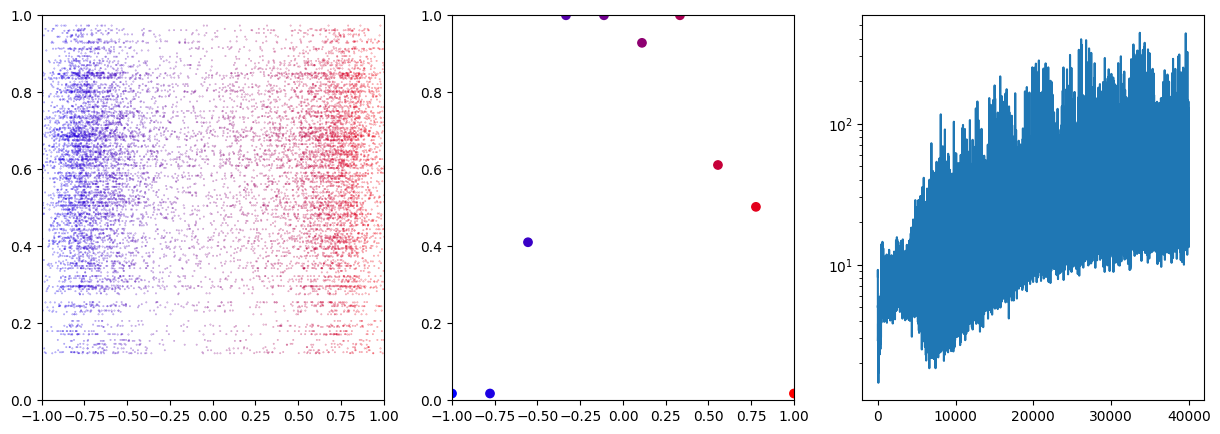

Epoch: 40000, 	 Loss: 1.9e+01,	 Normal Loss: 1.4e-02, 	 count : 2.0e+06, 	 Reward : 9.5e-01
[0.01758802 0.01758802 0.4104801  1.         1.         0.9284028
 1.         0.6111192  0.50241256 0.01758802]


In [ ]:
from IPython.display import display, clear_output
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
# fig,ax=plt.subplots(1,2,figsize=(10,5))

C=[]
X=[]
Loss=[]
for i in range(episode):
    xct=env.reset()
    obs = env.state2obs(xct)
    if epoch>(40000-1):
        break
    while True:
        u_action, v_action,action_id,action_dist = eval_net.act(torch.FloatTensor(np.expand_dims(obs, 0)))
        count += 1
        n_xct, reward, Done, _  = env.step(u_action,v_action)
        x, c, t = n_xct[:N], n_xct[N:-1], n_xct[-1]
        next_obs = env.state2obs(n_xct)
        buffer.store(obs, action_id, reward, next_obs, Done)
        reward_total.append(reward)
        obs = next_obs
        if len(buffer.memory) > batch_size:
            if count % 50 == 0:
                epoch+=1
                loss_p,loss_n,q_print=train(buffer, target_net, eval_net, gamma, optimizer, batch_size, loss_fn, count, update_freq,TAU)
                Loss.append(loss_p)
                for key in eval_net.state_dict():
                      avg_net.state_dict()[key] = eval_net.state_dict()[key]/100 + avg_net.state_dict()[key]
                if epoch%100==0:
                    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                    # ax[0].scatter(x=np.array(X)[:].flatten(), y=np.repeat(env.s.squeeze(),np.array(X).shape[0]), c=np.array(X)[:].flatten(),s=1, cmap=cmap)
                    ax[0].scatter(x=np.array(X)[:].flatten(), y=np.repeat(env.s.squeeze(),np.array(X).shape[0]), c=np.array(X)[:].flatten(),s=.1, cmap=cmap,alpha=.5)
                    ax[0].set_ylim(0, 1)
                    ax[0].set_xlim(-1, 1)
                    ax[1].scatter(x=np.linspace(-1, 1, env.M), y=np.array(C).mean(axis=0), c=np.linspace(-1, 1, env.M), cmap=cmap)
                    ax[1].set_ylim(0, 1)
                    ax[1].set_xlim(-1, 1)
                    ax[2].semilogy(np.array(Loss))

                    clear_output(wait=True)  # Clear the output of the existing plot before redrawing
                    display(plt.gcf())  # Display the current figure
                    print(f'Epoch: {epoch}, \t Loss: {np.array(Loss).mean():.1e},\t Normal Loss: {loss_n:.1e}, \t count : {count:.1e}, \t Reward : {np.array(reward_total).mean():.1e}')
                    print(np.array(C).mean(axis=0))
                    reward_total=[]
                    avg_net.load_state_dict(eval_net.state_dict())
                    # Loss=[]
                    C=[]
                    X=[]
                    # save_filename = f'eval_net_min_loss.pt'  # Name the file indicating it's the best model so far
                    # torch.save(target_net.state_dict(), save_path + save_filename)
                    plt.close(fig)  # Close the figure to free resource
        if Done:
            C.append(c)
            X.append(x)
            break


# Results

count= 30,	 Mean reward: -0.059, 	 total reward: -0.089


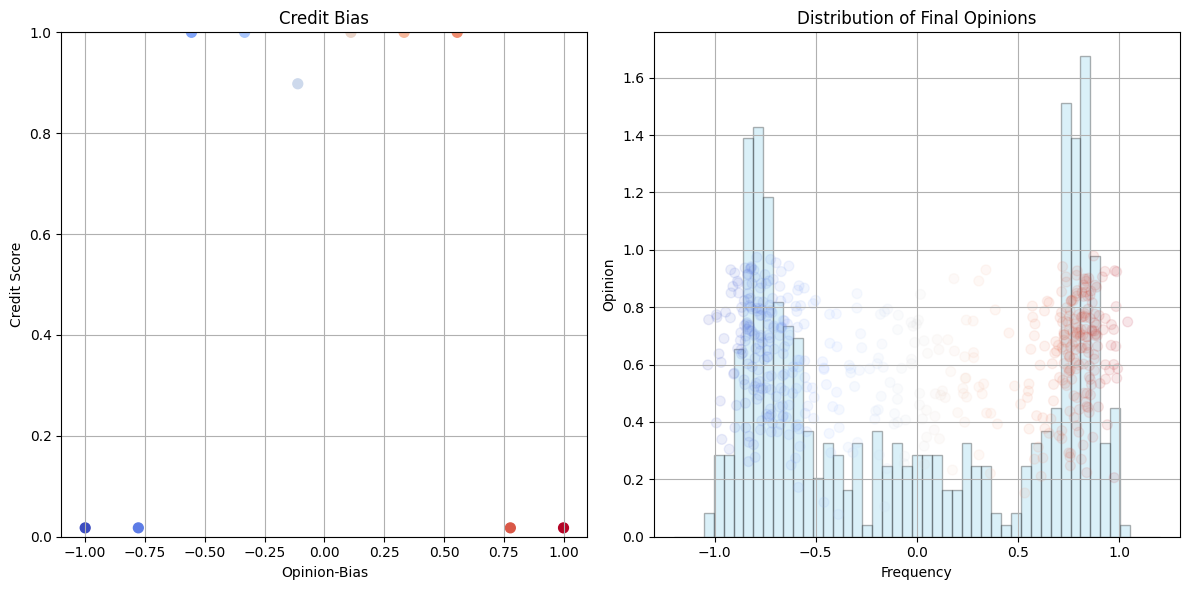

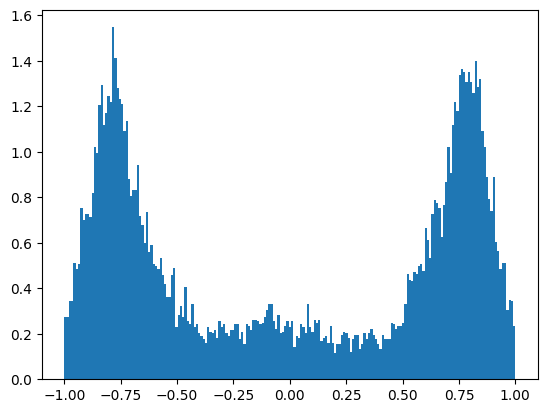

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch  # Assuming you're using PyTorch since state is a torch tensor



# save_path='/content/gdrive/My Drive/UT/Data/complete_action_200_res'+str(M)+'_b'+str(bpl)+'_D'+str(Duration)

# save_filename = f'eval_net_min_loss.pt'  # Name the file indicating it's the best model so far
# torch.save(eval_net.state_dict(), save_path + save_filename)
test_net=soft_q_net(observation_dim, bpl,bop,M,action_dimension )
test_net.load_state_dict(torch.load(save_path + 'eval_net_min_loss.pt'))
# test_net.load_state_dict(avg_net.state_dict())
# test_net.load_state_dict(target_net.state_dict())
c_mean=torch.zeros(M)
x_mean=[]
rep=30
count = 0
R_mean=0
for j in range(rep):
    total_reward = 0
    done = False
    X = torch.zeros((N,env.terminal_time))
    C = torch.zeros((M,env.terminal_time))
    with torch.no_grad():
      xct = env.reset()
      for loop in range(1):
            obs = env.state2obs(xct)
            reward_total = 0
            while True:
                u_action, v_action,action_id,_ = test_net.act(torch.FloatTensor(np.expand_dims(obs, 0)))
                # if np.random.rand()>0.7:
                    # print('rand')
                    # v_action=np.random.randint(32)
                # if np.random.rand()>0.9:
                    # print('rand')
                    # u_action=np.random.randint(32)
                n_xct, reward, Done, _  = env.step(u_action,v_action)
                next_obs = env.state2obs(n_xct)
                x, c, t = n_xct[:N], n_xct[N:-1], n_xct[-1]
                reward_total += reward/env.terminal_time
                obs = next_obs
                C[:,t.int()-1]=c
                X[:,t.int()-1]=x
                if Done:
                    count += 1
                    c_mean+=c/rep
                    x_mean.append(x)
                    R_mean+=reward_total/rep
                    break

print(f'count= {count},\t Mean reward: {R_mean:0.3f}, \t total reward: {reward_total:0.3f}')

env.plot_dist(x,c_mean)
plt.hist(np.ravel(np.array(x_mean)),bins=np.linspace(-1,1,200),density=True)
if 0:
  env.plot_dist(x,c)
  plt.figure(figsize=(12, 6))
  Tvec = np.arange(env.terminal_time)
  cmap = plt.cm.coolwarm  # Choose blue-white-red colormap
  plt.figure(figsize=(15, 6))
  plt.scatter(np.tile(Tvec, (N, 1)), X,100, c=X, cmap=cmap, alpha=.03)
  plt.xlabel('Time')
  plt.ylabel('Opinon')
  plt.show()

In [ ]:
clc


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'clc' is not defined

IndexError: too many indices for tensor of dimension 1

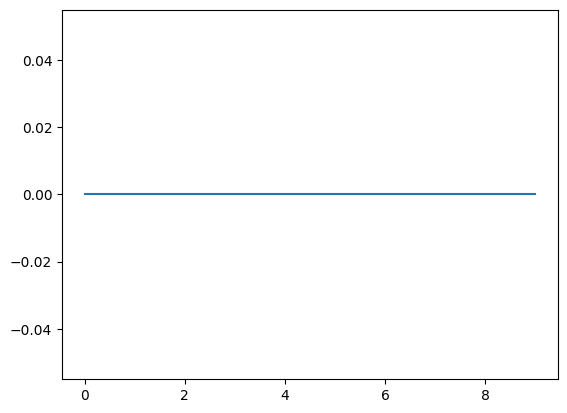

In [ ]:
plt.plot(C.t().numpy())
tT=50
env.plot_dist(X[:,-1],C[:,-1])

In [ ]:
with torch.no_grad():
  observation=torch.FloatTensor(np.expand_dims(obs, 0))
  q_value = eval_net.forward(observation)
  Q_pl=eval_net.getQ_pl(q_value)
  Q_op=eval_net.getQ_op(q_value)
  pi_pl=F.softmax(eval_net.bpl*Q_pl, dim=-1)
  pi_op=F.softmax(eval_net.bop*Q_op, dim=-1)

  dist_pl = torch.distributions.Categorical(pi_pl)
  dist_op = torch.distributions.Categorical(pi_op)
  ac_pl=dist_pl.sample().item()
  ac_op=dist_op.sample().item()
  ac_id=ac_pl*eval_net.action_dim+ac_op

In [ ]:
q_value.min()-q_value.max()

tensor(-0.0885)

Episode 200.0: Total Reward: -0.015307396650314331



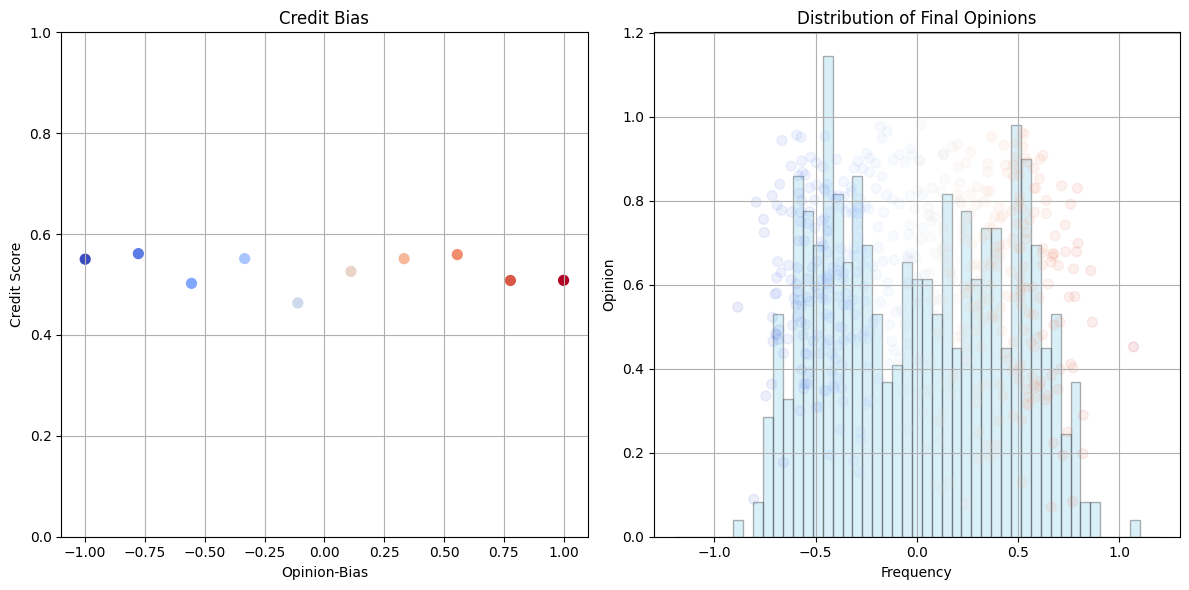

In [ ]:
M=10
N = 500

terminal_time=200
Duration=int(terminal_time/5)
nbins=10
env = PointOnThePlaneTorch(N=N, M=M, terminal_time = terminal_time,bM=5,b=20,noise_level=0.1,duration=1,h=torch.tensor(.1),nbins=nbins,r_scale=1)
env.reset()

state = env.reset()
total_reward = 0
done = False

X = []
C = []
t=0
while not done:
    u=torch.randint(32, (1,)).int()
    v=torch.randint(32, (1,)).int()
    state, reward, done, _ = env.step(u.item(),v.item())
    # print(reward)
    total_reward += reward
    x, c, t = state[:N], state[N:-1], state[-1]
    X.append(x)
    C.append(c)
print(f"Episode {t}: Total Reward: {reward}\n")
env.plot_dist(x,c)


In [ ]:
with torch.no_grad():
    observation, action, reward, next_observation, done = buffer.sample(batch_size)
    observation = torch.FloatTensor(observation)
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    next_observation = torch.FloatTensor(next_observation)
    done = torch.FloatTensor(done)

    q_values = eval_net.forward(observation)
    next_q_values = target_net.forward(next_observation)
    next_v_values = target_net.getV(next_q_values)
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * (1 - done) * next_v_values.squeeze(-1)
    loss = (expected_q_value.detach() - q_value).pow(2)/q_value.var()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(391.9111)

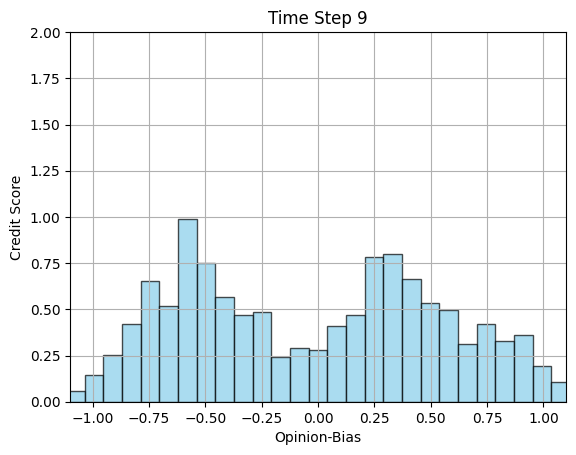

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
n, bins, patches = ax.hist(X[0], np.linspace(-1.2,1.2,10),density=True)

def init():
    ax.set_xlabel("Opinion-Bias")
    ax.set_ylabel("Credit Score")
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([0, 2])
    ax.grid(True)
    return patches,

def update(i):
    ax.clear()
    ax.set_xlabel("Opinion-Bias")
    ax.set_title(f"Time Step {i}")
    ax.set_ylabel("Credit Score")
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([0, 2])
    ax.grid(True)
    n, bins, patches = ax.hist(X[i], np.linspace(-1.2,1.2,30),color='skyblue', edgecolor='black', alpha=0.7,density=True)
    return patches,

ani = FuncAnimation(fig, update, frames=range(len(X)), init_func=init, blit=False)

# # # To display the animation in Google Colab
HTML(ani.to_html5_video())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


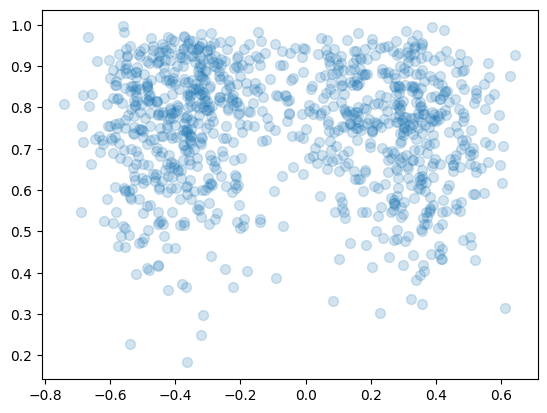

In [ ]:
plt.scatter(x,env.s,50,alpha=0.2)

In [ ]:
xct=env.reset()
obs = env.state2obs(xct)
self=eval_net
observation = torch.FloatTensor(np.expand_dims(obs, 0))
q_value = self.forward(torch.FloatTensor(np.expand_dims(obs, 0)))
Q_pl=self.getQ_pl(q_value)
Q_op=self.getQ_op(q_value)
pi_pl=F.softmax(self.bpl*Q_pl, dim=-1)
pi_op=F.softmax(self.bop*Q_op, dim=-1)

dist_pl = torch.distributions.Categorical(pi_pl)
dist_op = torch.distributions.Categorical(pi_op)
ac_pl=dist_pl.sample().item()
ac_op=dist_op.sample().item()
ac_id=ac_pl*self.action_dim+ac_op
print(pi_pl.detach().numpy())
print(pi_op.detach().numpy())
# print(ac_pl,ac_,ac_id)


observation, action, reward, next_observation, done = buffer.sample(32)
observation = torch.FloatTensor(observation)
action = torch.LongTensor(action)
reward = torch.FloatTensor(reward)
next_observation = torch.FloatTensor(next_observation)
done = torch.FloatTensor(done)
q_values = eval_net.forward(observation)
next_q_values = target_net.forward(next_observation)
next_v_values = target_net.getV(next_q_values)
q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
expected_q_value = reward + gamma * (1 - done) * next_v_values.squeeze(-1)

print(q_values)
with torch.no_grad():
  loss = (expected_q_value.detach() - q_value).pow(2)
  loss = loss.mean()
  # print(loss)
  # print(q_value)

[[0.924 0.076 0.000 0.000]]
[[0.047 0.155 0.000 0.798]]
tensor([[-0.0183, -0.0364,  0.2285,  0.0646, -0.0614, -0.0234,  0.0404,  0.0106,
         -0.1314,  0.0723,  0.0020, -0.0321,  0.0950,  0.0777, -0.1141, -0.1508],
        [-0.0194, -0.0362,  0.2285,  0.0672, -0.0624, -0.0233,  0.0415,  0.0104,
         -0.1312,  0.0719,  0.0027, -0.0325,  0.0955,  0.0789, -0.1143, -0.1511],
        [-0.0189, -0.0360,  0.2283,  0.0652, -0.0624, -0.0233,  0.0407,  0.0110,
         -0.1322,  0.0719,  0.0025, -0.0326,  0.0961,  0.0777, -0.1145, -0.1509],
        [-0.0189, -0.0369,  0.2281,  0.0675, -0.0621, -0.0223,  0.0409,  0.0104,
         -0.1306,  0.0716,  0.0023, -0.0317,  0.0954,  0.0787, -0.1138, -0.1517],
        [-0.0194, -0.0356,  0.2288,  0.0670, -0.0614, -0.0244,  0.0425,  0.0097,
         -0.1306,  0.0725,  0.0026, -0.0326,  0.0943,  0.0787, -0.1141, -0.1504],
        [-0.0190, -0.0364,  0.2281,  0.0670, -0.0630, -0.0229,  0.0411,  0.0107,
         -0.1313,  0.0717,  0.0028, -0.0325,  0.

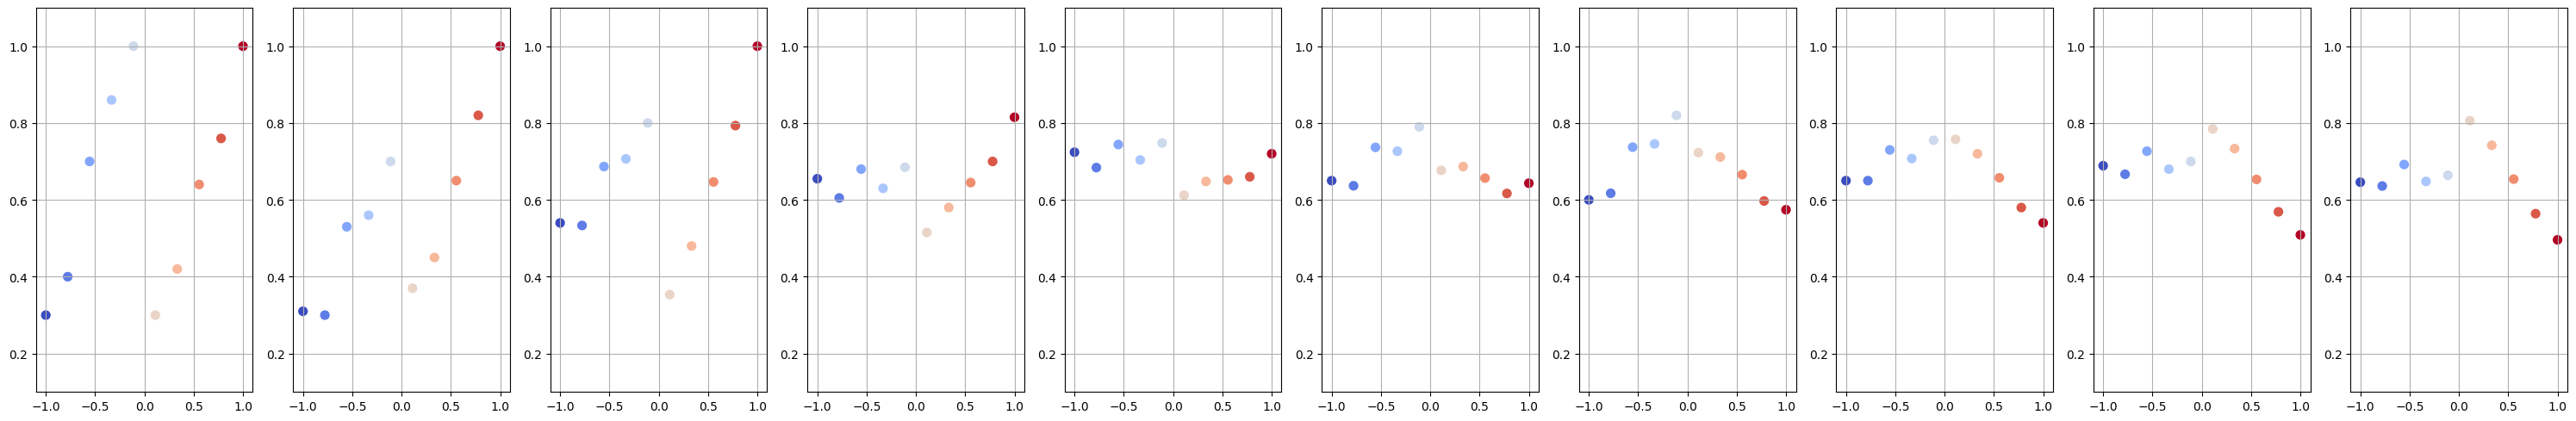

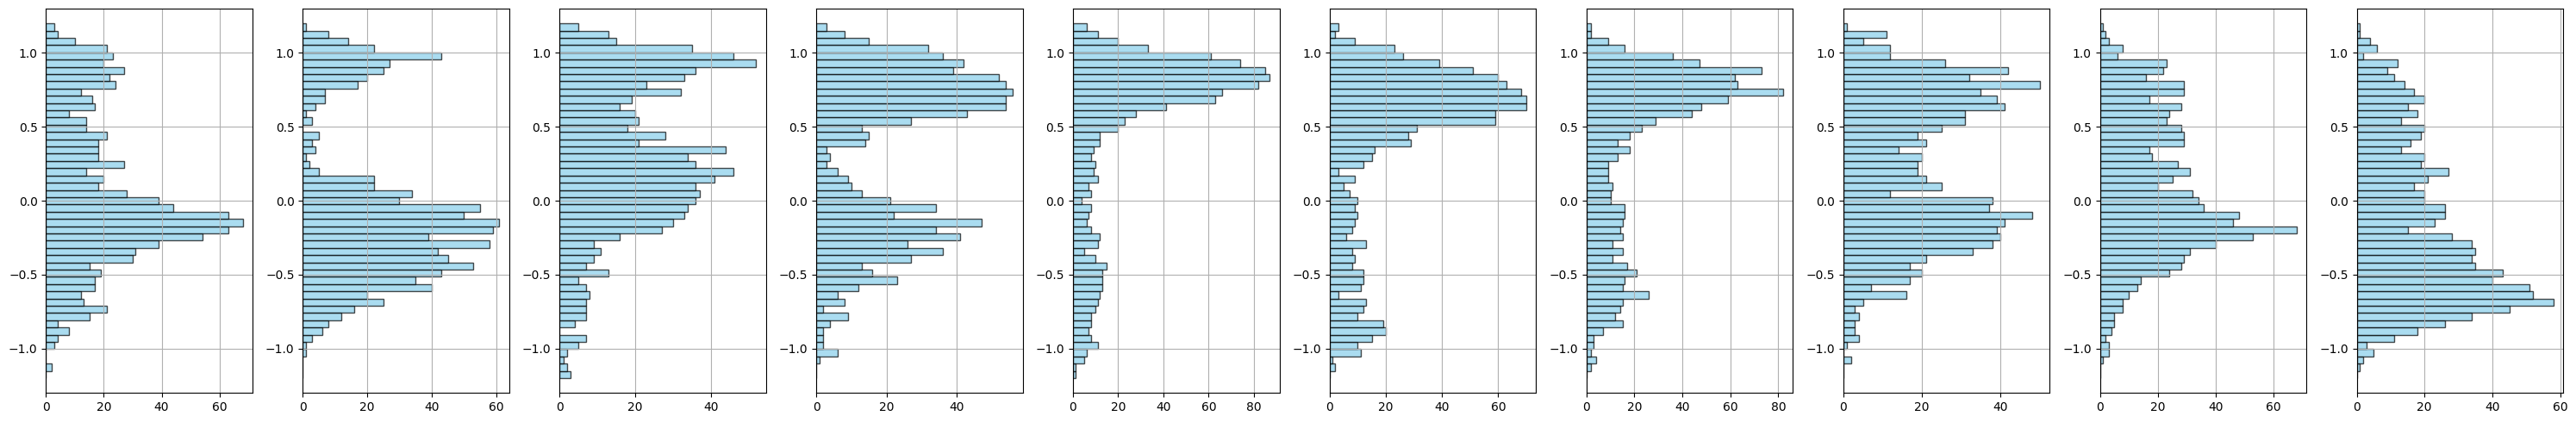

In [ ]:
num_plots = len(X)
plt.figure(figsize=(num_plots * 3, 5))  # Adjust the figure size as needed

# Loop through each item in X and create a subplot
for i in range(num_plots):
    plt.subplot(1, num_plots, i + 1)  # 1 row, num_plots columns, current plot (i+1)
    plt.scatter(ym,C[i].numpy(),50,c=ym,cmap=cmap)
    plt.grid(True)
    plt.ylim([.1, 1.1])

plt.tight_layout()
plt.show()


plt.figure(figsize=(num_plots * 3, 5))  # Adjust the figure size as needed
for i in range(num_plots):
    plt.subplot(1, num_plots, i + 1)  # 1 row, num_plots columns, current plot (i+1)
    plt.hist(X[i].numpy(), np.linspace(-1.2, 1.2, 50), orientation='horizontal', color='skyblue', edgecolor='black', alpha=0.7)
    plt.grid(True)
    plt.ylim([-1.3, 1.3])

plt.tight_layout()
plt.show()

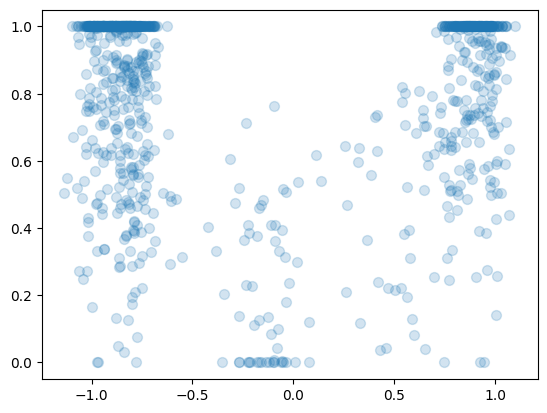

In [ ]:
plt.scatter(x,env.s,50,alpha=0.2)

In [ ]:
C[i].shape
ym.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([10])